# 3D transformation

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
print('\n')
# ------------------
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from os.path import isfile
import sys
from time import time
import cv2
import numpy as np
from os.path import join, isdir
sys.path.append('./../../easy_multi_person_pose_estimation')
sys.path.insert(0,'../')
import mvpose.data.transform as tfm

root = join(Settings['data_root'], 'pak')

from poseestimation import model
pe = model.PoseEstimator()

from pak.datasets.UMPM import UMPM
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']

X, Y, Calib = tfm.get_from_umpm(root, 'p2_free_1', user, pwd)

/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


UMPM


## Show found points

In [2]:
# fig = plt.figure(figsize=(16,13))

# def handle_img(ax, cam, frame):
#     x = X[cam][frame]
#     _start = time()
#     positions = pe.predict(x)
#     _end = time()
#     print()
#     print('cam ' + str(cam+1) + '\telapsed:', _end - _start)

#     positions = tfm.transform_from_openpose(positions)
#     positions_frame0 = positions[0]
#     for k in positions_frame0:
#         for x,y in k:
#             if x > 0 and y > 0:
#                 ax.scatter(y,x, color='red')
#     ax.imshow(X[cam][frame])
#     return positions[0]
    
# frame = 0
# fig = plt.figure(figsize=(16,13))
# pos_cam1 = handle_img(fig.add_subplot(221), 0, frame=frame)
# pos_cam2 = handle_img(fig.add_subplot(222), 1, frame=frame)
# pos_cam3 = handle_img(fig.add_subplot(223), 2, frame=frame)
# pos_cam4 = handle_img(fig.add_subplot(224), 3, frame=frame)
# plt.show()

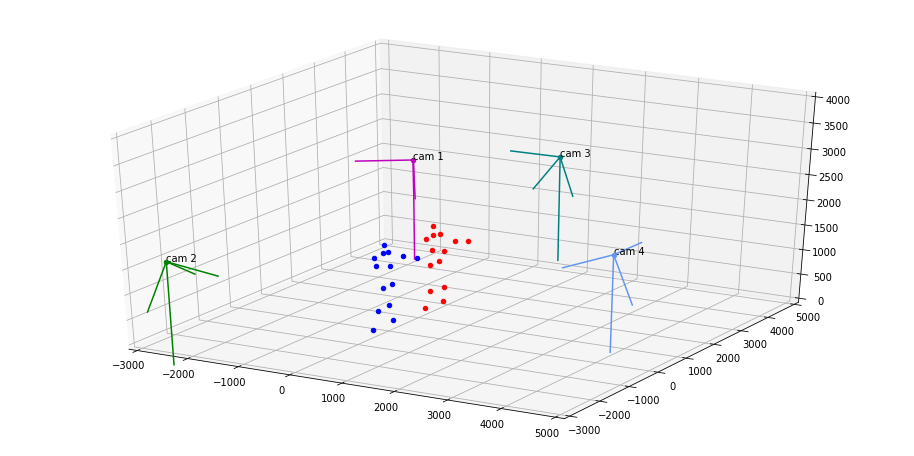

In [3]:
import numpy.linalg as la

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-3000, 5000])
ax.set_ylim([-3000, 5000])
ax.set_zlim([0, 4000])


cam_color = ['m', 'g', 'teal', 'cornflowerblue']
for i,cam in enumerate(Calib):
    R = cv2.Rodrigues(np.array(cam['rvec']))[0]
    t = np.array(cam['tvec'])
    P = -np.transpose(R) @ t
    x,y,z = P
    ax.scatter(x,y,z, color=cam_color[i])
    ax.text(x,y,z, 'cam ' + str(i+1))
    ax.plot([x,x], [y,y], [0,z], color=cam_color[i])
    
    M = np.transpose(R.copy())
    base = M[:,0]
    yaxis = M[:,1]
    lookat = M[:,2]
    f = 1000
    
    for e in [lookat,yaxis,base]:
        p2 = P + e * f
        ax.plot([P[0], p2[0]], [P[1], p2[1]], [P[2], p2[2]], color=cam_color[i])


color = ['red', 'blue']
for x,y,z,pid in Y[0]:
    ax.scatter([x],[y],[z], color=color[int(pid)])


plt.show()

## Generate 3D heatmaps

In [4]:
I = np.array([X[0][0], X[1][0], X[2][0], X[3][0]])
with_gpu = False

if with_gpu:
    _start = time()
    heatmaps, pafs = pe.predict_pafs_and_heatmaps(I)
    _end = time(); print('elapsed:', _end - _start)
else:
    
    if isfile('/tmp/heatmaps.npy') and isfile('/tmp/pafs.npy'):
        heatmaps = np.load('/tmp/heatmaps.npy')
        pafs = np.load('/tmp/pafs.npy')
    else:
        heatmaps = []; pafs = []
        for im in I:
            _start = time()
            hm, paf = pe.predict_pafs_and_heatmaps(im)
            heatmaps.append(np.squeeze(hm))
            pafs.append(np.squeeze(paf))
            _end = time()
            print('elapsed:', _end - _start)
        heatmaps = np.array(heatmaps)
        pafs = np.array(pafs)
        np.save('/tmp/heatmaps.npy', heatmaps)
        np.save('/tmp/pafs.npy', pafs)

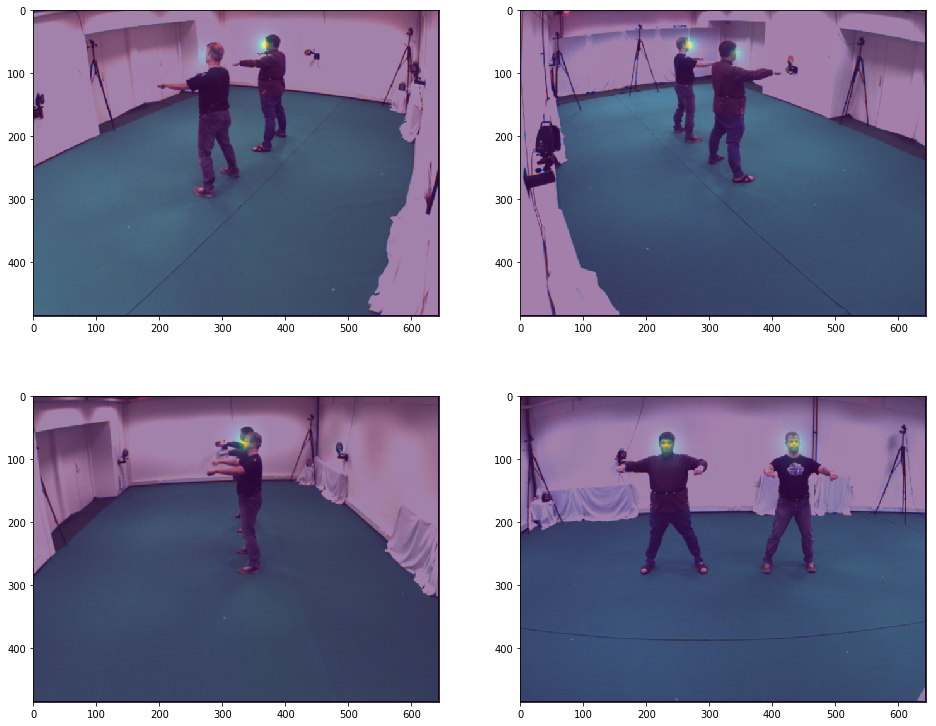

In [5]:
fig = plt.figure(figsize=(16,13))
Noses = []
for i,(hm,im) in enumerate(zip(heatmaps,I)):
    nose = hm[:,:,0]
    Noses.append(nose)
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(im); ax.imshow(nose, alpha=0.5)
plt.show()

Noses = np.array(Noses)

## un-distort heatmaps and vector fields

(4, 486, 644, 38)


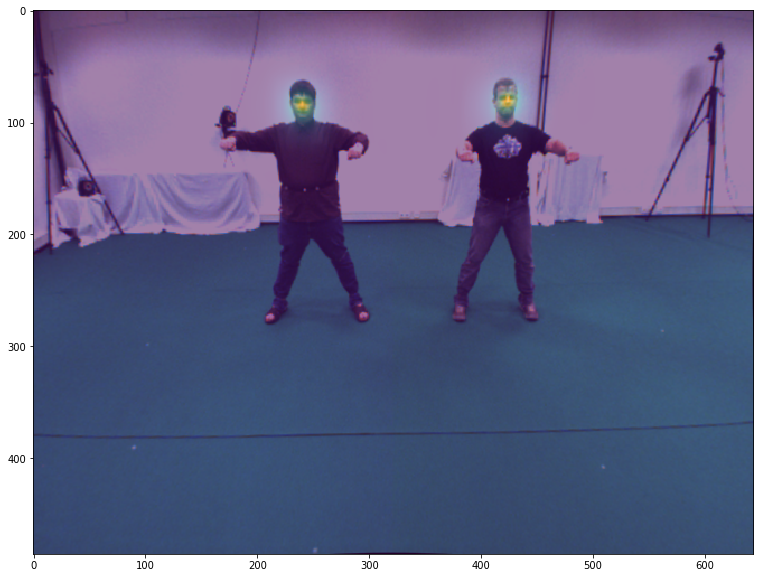

In [6]:
from mvpose.geometry import stereo
from mvpose.geometry import geometry as gm

cam = 3

print(pafs.shape)

hm = heatmaps[cam]

nose = Noses[cam]
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
Im = I[cam]

# ---
K, rvec, tvec, distCoef = gm.get_camera_parameters(Calib[cam])

Im_ud, K_ud = gm.remove_distortion(Im, Calib[cam])
hm_ud, K_ud = gm.remove_distortion(hm, Calib[cam])

ax.imshow(Im_ud)
ax.imshow(hm_ud[:,:,0], alpha=0.5)
plt.show()

## 2d cost association

elapsed 0.3413252830505371


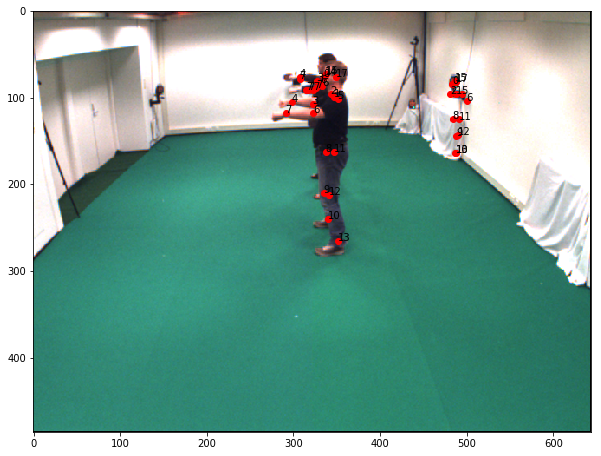

In [7]:
from time import time
from numba import jit
import mvpose.algorithm.heatmaps as mvhm


cam = 2
Im = I[cam]

    
_start = time()
peaks = mvhm.get_all_peaks(heatmaps[cam])
_end = time()
print('elapsed', _end - _start)


fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

ax.imshow(Im)

for i,loc_peaks in enumerate(peaks):
    for x,y,_ in loc_peaks:
        ax.scatter(x,y,color='red')
        ax.text(x,y, str(i))

plt.show()

347.0
elapsed 0.00077056884765625
[[-1.22790318e+00  5.52646975e-04]
 [ 1.63009971e-02  9.09467221e-01]]


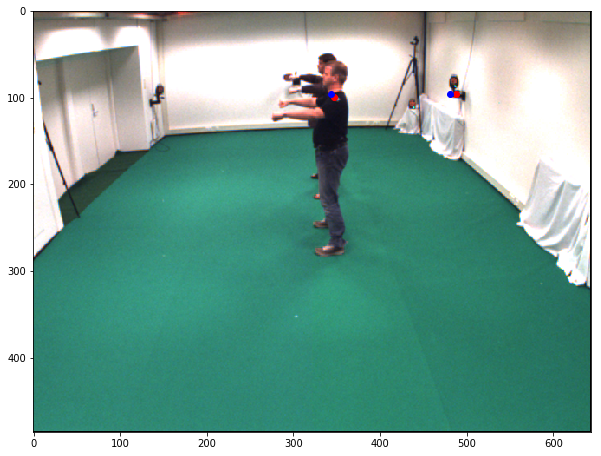

In [8]:
from numba import jit
import math
import numpy.linalg as la
import mvpose.algorithm.part_affinity_fields as mvpafs

paf_avg = pafs[3]

# find connection in the specified sequence, center 29 is in the position 15
limbSeq = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7], [1,8], [8,9], \
           [9,10], [1,11], [11,12], [12,13], [1,0], [0,14], [14,16], \
           [0,15], [15,17], [2,16], [5,17]]
# the middle joints heatmap correpondence
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], [19,20], [21,22], \
          [23,24], [25,26], [27,28], [29,30], [47,48], [49,50], [53,54], [51,52], \
          [55,56], [37,38], [45,46]]


fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

k = 0
mid_num = 5

score_mid = paf_avg[:,:,[x-19 for x in mapIdx[k]]]
candA = peaks[limbSeq[k][0]]
candB = peaks[limbSeq[k][1]]


indexA, indexB = limbSeq[k]

connection_candidate = []

candA = np.array(candA, 'float64')
candB = np.array(candB, 'float64')

print(candA[0][0])


#calculate_weights(candA, candB)

_start = time()
W = mvpafs.calculate_weights(candA, candB, score_mid)
_end = time()
print('elapsed', _end - _start)

print(W)

for x,y,_ in candA:
    ax.scatter(x,y,color='red')

for x,y,_ in candB:
    ax.scatter(x,y,color='blue')

ax.imshow(Im)
plt.show()

## pafs

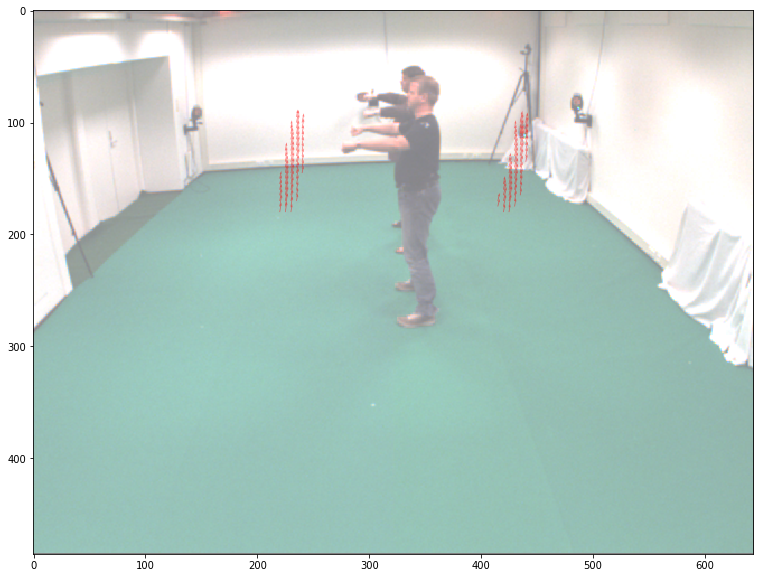

In [9]:
paf_avg = pafs[3]
from numpy import ma

limb = 0

U = paf_avg[:,:,(limb*2)] * -1
V = paf_avg[:,:,(limb*2)+1]
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
M = np.zeros(U.shape, dtype='bool')
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

# 1
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
plt.imshow(Im, alpha = .5)
s = 5
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

# fig = matplotlib.pyplot.gcf()
# fig.set_size_inches(20, 20)

## 3D heatmap projection

In [10]:
# step 1: we need to 'un-distort' the points
# step 2: least-square fitting the points
# step 3: keep on going...

# undistort heatmaps
heatmaps_ud = []
Im_ud_s = []
K_ud_s = []

for cam in range(4):
    hm_ud, K_ud = gm.remove_distortion(heatmaps[cam], Calib[cam])
    heatmaps_ud.append(hm_ud)
    K_ud_s.append(K_ud)
    
    Im_ud, K_ud = gm.remove_distortion(I[cam], Calib[cam])
    Im_ud_s.append(Im_ud)
# generate P's
Ps = []
for cam in range(4):
    _, rvec, tvec, _ = gm.get_camera_parameters(Calib[cam])
    P = gm.get_projection_matrix_flat(K_ud_s[cam], rvec, tvec)
    Ps.append(P)

peaks_per_camera = []
_start = time()
for hm in heatmaps_ud:
    peaks = mvhm.get_all_peaks(hm)
    peaks_per_camera.append(peaks)
_end = time()
print('elapsed', _end - _start)
#TODO this is definitely too slow

elapsed 1.3534045219421387


UMPM


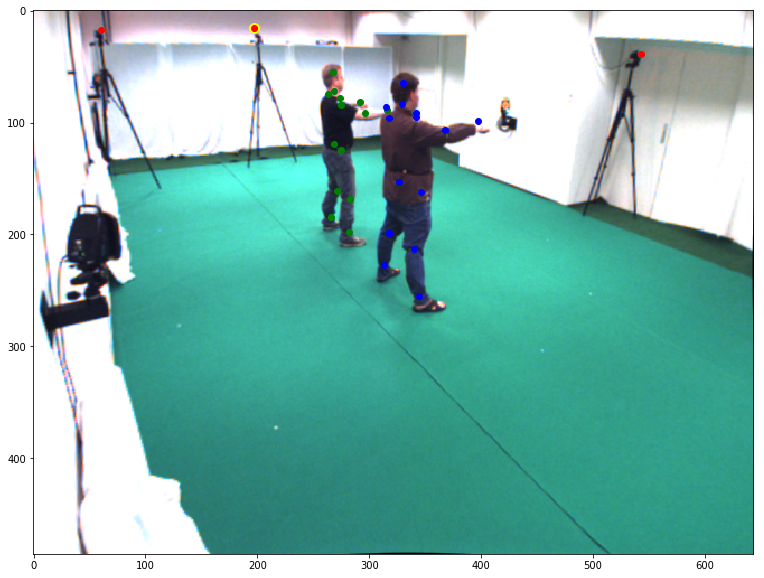

In [11]:
# lets start with the noses...

X, Y, Calib = tfm.get_from_umpm(root, 'p2_free_1', user, pwd)

Noses = [pks[0] for pks in peaks_per_camera]

c1 = gm.get_camera_pos_in_world_coords(Calib[0])
c4 = gm.get_camera_pos_in_world_coords(Calib[3])
c3 = gm.get_camera_pos_in_world_coords(Calib[2])
P2 = Ps[1]

def get_epipoles(cam1, cam2):
    K1 = K_ud_s[cam1]
    _, rvec1, tvec1, _ = gm.get_camera_parameters(Calib[cam1])
    K2 = K_ud_s[cam2]
    _, rvec2, tvec2, _ = gm.get_camera_parameters(Calib[cam2])
    return stereo.get_epipoles_undistorted(K1, rvec1, tvec1,
                                            K2, rvec2, tvec2)

im2_e3, im3_e2 = get_epipoles(1,2)

# ... and lets run a sanity check to see if the projection
# matrix is kinda reliable..

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
ax.imshow(Im_ud_s[1])


ax.scatter(im2_e3[0], im2_e3[1], color='yellow', s=100)

u,v = gm.from_homogeneous(P2@gm.to_homogeneous(c3))
ax.scatter(u,v, color='red')

u,v = gm.from_homogeneous(P2@gm.to_homogeneous(c1))
ax.scatter(u,v, color='red')

u,v = gm.from_homogeneous(P2@gm.to_homogeneous(c4))
ax.scatter(u,v, color='red')

color_per_pid = ['green', 'blue']
for x,y,z,pid in Y[0]:
    p = gm.to_homogeneous([x,y,z])
    u,v = gm.from_homogeneous(P2@p)
    ax.scatter(u,v, color=color_per_pid[int(pid)])

plt.show()

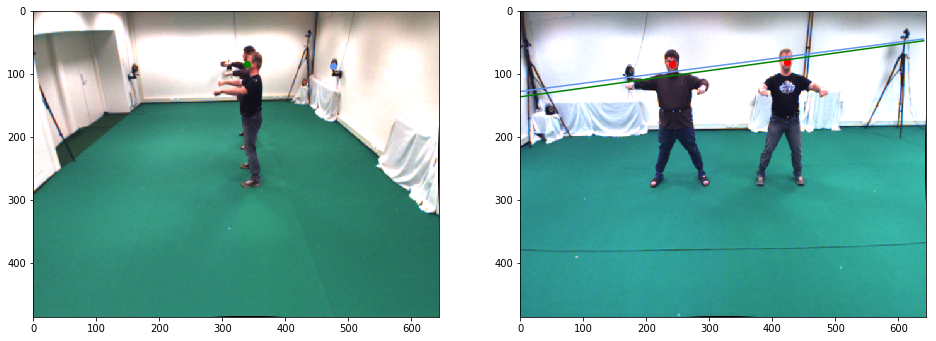

In [12]:
cam1 = 2; cam2 = 3

#F = stereo.get_fundamental_matrix(Calib[cam1], Calib[cam2])
K1, rvec1, tvec1, distCoef1 = gm.get_camera_parameters(Calib[cam1])
K2, rvec2, tvec2, distCoef2 = gm.get_camera_parameters(Calib[cam2])

K1 = K_ud_s[cam1]
K2 = K_ud_s[cam2]


F = stereo.get_fundamental_matrix_flat(K1, rvec1, tvec1, 0,
                                       K2, rvec2, tvec2, 0)


# ---------


color = ['cornflowerblue', 'green']

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(121); ax.imshow(Im_ud_s[cam1])
for idx, (x,y,_) in enumerate(Noses[cam1]):
    ax.scatter(x,y,color=color[idx])
ay = fig.add_subplot(122); ay.imshow(Im_ud_s[cam2])
#ay = fig.add_subplot(122); ay.imshow(I[cam2])
for x,y,_ in Noses[cam2]:
    ay.scatter(x,y,color='red')
    
points = np.array(Noses[cam1])[:,:2]
res = np.squeeze(cv2.computeCorrespondEpilines(points, 1, F))
if len(res.shape) <= 1:
    res = np.expand_dims(res, axis=0)
    
    
for idx, (a,b,c) in enumerate(res):
    
    # cost
#     cost = lambda x,y: line_to_point_distance(a,b,c,x,y)
#     for x,y,_ in Noses[cam2]:
#         print('cost:', cost(x,y))
    
    # res: ax + by + c = 0
    f = lambda x:(a*x+c)/(-b)
    points = []
    for x in [0, 640]:
        y = f(x)
        points.append((x,y))
    points = np.array(points)
    ay.plot(points[:,0], points[:,1], color=color[idx])
    

    
plt.show()

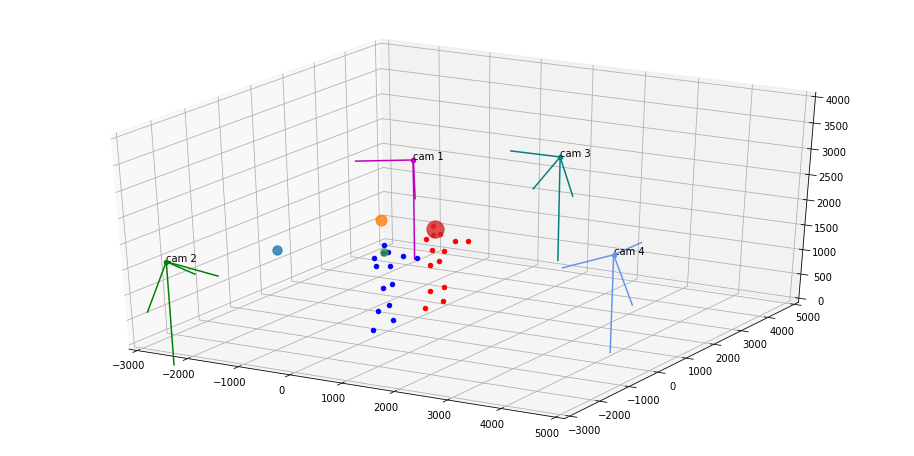

In [13]:
# ==============

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-3000, 5000])
ax.set_ylim([-3000, 5000])
ax.set_zlim([0, 4000])


cam_color = ['m', 'g', 'teal', 'cornflowerblue']
for i,cam in enumerate(Calib):
    R = cv2.Rodrigues(np.array(cam['rvec']))[0]
    t = np.array(cam['tvec'])
    P = -np.transpose(R) @ t
    x,y,z = P
    ax.scatter(x,y,z, color=cam_color[i])
    ax.text(x,y,z, 'cam ' + str(i+1))
    ax.plot([x,x], [y,y], [0,z], color=cam_color[i])
    
    M = np.transpose(R.copy())
    base = M[:,0]
    yaxis = M[:,1]
    lookat = M[:,2]
    f = 1000
    
    for e in [lookat,yaxis,base]:
        p2 = P + e * f
        ax.plot([P[0], p2[0]], [P[1], p2[1]], [P[2], p2[2]], color=cam_color[i])


color = ['red', 'blue']
for x,y,z,pid in Y[0]:
    ax.scatter([x],[y],[z], color=color[int(pid)])

# ==============

cam1 = 2; cam2 = 3

K1, rvec1, tvec1, distCoef1 = gm.get_camera_parameters(Calib[cam1])
K2, rvec2, tvec2, distCoef2 = gm.get_camera_parameters(Calib[cam2])
K1 = K_ud_s[cam1]
K2 = K_ud_s[cam2]

P1 = gm.get_projection_matrix_flat(K1, rvec1, tvec1)
P2 = gm.get_projection_matrix_flat(K2, rvec2, tvec2)

F = stereo.get_fundamental_matrix_flat(K1, rvec1, tvec1, 0,
                                       K2, rvec2, tvec2, 0)

points1 = np.array(Noses[cam1])[:,:2]
points2 = np.array(Noses[cam2])[:,:2].astype('float32')
res = np.squeeze(cv2.computeCorrespondEpilines(points1, 1, F))

Gaussians = []

for p, l in zip(points1, res):
    x1,y1 = p
    a,b,c = l
    
    distance = gm.line_to_point_distance(a,b,c,points2[:,0], points2[:,1])
    weights = 1/distance
    
    n = len(points2)
    Pts2 = np.transpose(points2)
    Pt1 = np.transpose(np.expand_dims(p, axis=0).repeat(n, axis=0))
    
    pts3d = np.transpose(cv2.triangulatePoints(P1, P2, Pt1, Pts2))
    pts3d = gm.from_homogeneous(pts3d)
    
    for idx, (x,y,z) in enumerate(pts3d):
        ax.scatter(x,y,z, s=1000*weights[idx], alpha=0.8)
    

plt.show()

In [14]:
# candA = peaks[limbSeq[k][0]]
# candB = peaks[limbSeq[k][1]]

# indexA, indexB = limbSeq[k]

# connection_candidate = []

# candA = np.array(candA, 'float64')
# candB = np.array(candB, 'float64')
# W = mvpafs.calculate_weights(candA, candB, score_mid)

# print(pafs.shape)
# print(heatmaps.shape)

# def calculate_weights_for_all_limbs(pafs):
#     pass

# @jit('double[:,:](double[:,:], double[:,:], double[:,:,:])', nopython=True, nogil=True)
# def calculate_weights(candA, candB, score_mid):


@jit('float32[:](float32)', nopython=True, nogil=True)
def calculate_weights(a):
    return np.array([a])


print(calculate_weights(4))

[4.]


In [15]:
from mvpose.algorithm import candidate_generator

#candidate_generator.generate_candidates(heatmaps, pafs)